In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy, os,csv

from skimage import io, exposure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.draw import disk as pdisk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_otsu, threshold_multiotsu, rank
from skimage.filters import sobel

from scipy.stats import skew
from scipy.signal import argrelextrema


/home/user/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
scan_path_root = "/mnt/ula/catfish/test_scans/"

dapi_suffix = "/1.tif"
overlay_suffix = "/overlay.tif"
csv_suffix = "/2.csv"
hist_suffix = "/hist.png"

In [3]:
class Approximation(): 
    def __init__(self, reg_props, approx_patch, intensity,  idno):
        self.reg_props = reg_props
        self.approx_patch = approx_patch
        self.intensity = intensity
        self.idno = idno

class ImgParamsPA(): 
    def __init__(self, path, objects):
        self.path = path
        self.objects = objects

class Nucleus(): 
    def __init__(self, nucelusProps, approxEllipse,  idno):
        self.nucelusProps = nucelusProps
        self.approxEllipse = approxEllipse
        self.idno = idno

In [4]:
def divide_region_approx_ellipse(region, last_id):
    new_nuclei = np.array([])
    alpha = (-180/math.pi)*(region.orientation)
    shift_x = 0.25*region.major_axis_length*math.sin(math.radians(-alpha))
    shift_y = 0.25*region.major_axis_length*math.cos(math.radians(-alpha))
    approxEllipse = mpatches.Ellipse((region.centroid[1]-shift_x,region.centroid[0]-shift_y), region.minor_axis_length,
                                                             region.major_axis_length/2,alpha,
                           fill=False, edgecolor='red', linewidth=1)  
    new_nucleus = Approximation(region, copy.copy(approxEllipse), 0, last_id)
    
    new_nuclei = np.append(new_nuclei, new_nucleus) 
                
    approxEllipse = mpatches.Ellipse((region.centroid[1]+shift_x,region.centroid[0]+shift_y), 
                                                 region.minor_axis_length,
                                                             region.major_axis_length/2,alpha,
                           fill=False, edgecolor='red', linewidth=1)  
    new_nucleus = Approximation(region, copy.copy(approxEllipse), 0, last_id+1)
    new_nuclei = np.append(new_nuclei, new_nucleus)
    return new_nuclei

In [5]:
def prepare_region_approximation(region, last_id):
    alpha = (-180/math.pi)*(region.orientation)
    if region.minor_axis_length == 0:
        ax_ratio = 0
    else:
        ax_ratio = region.major_axis_length/region.minor_axis_length
    new_nuclei = np.array([])
    #suwak + histogram do ustalania tej wartości?
    if ax_ratio * region.area > 1500:
        new_nuclei = divide_region_approx_ellipse(region, last_id)
    else:
        approxEllipse = mpatches.Ellipse((region.centroid[1],region.centroid[0]), region.minor_axis_length,
                                                             region.major_axis_length,alpha,
                           fill=False, edgecolor='red', linewidth=1)  
        new_nuclei = np.append(new_nuclei, Approximation(region, copy.copy(approxEllipse), 0, last_id))

    
    return new_nuclei

In [6]:
def dapi_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    ratio_thre = 1.6
    
    image_ts_orig = copy.copy(image_ts)
    
    image_ts = opening(image_ts, disk(2))
    

    thresh = threshold_otsu(image_ts[image_ts>0])/2
    

    local_thresh = threshold_local(image_ts, thresh_range, offset=0)
    binary_local = image_ts > local_thresh

    
    local_masked_global = np.ma.masked_array(data = binary_local, 
                                             mask = ~(image_ts > thresh), fill_value = 0).filled()

    local_masked_global = opening(local_masked_global, disk(5))
    elev_map = sobel(mh.gaussian_filter(image_ts,3))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]
   
    labels = watershed(-elev_map, markers, mask=local_masked_global)
    label_image = label(labels, connectivity = 1)

    areas = np.array([])
    intensities = np.array([])
    ellipse_axes_ratios = np.array([])
    
    for region in regionprops(label_image, intensity_image=image_ts):
        areas = np.append(areas, region.area)
        intensities = np.append(intensities, region.mean_intensity)
        if region.minor_axis_length == 0:
            ax_ratio = 0
        else:
            ax_ratio = region.major_axis_length/region.minor_axis_length
        ellipse_axes_ratios = np.append(ellipse_axes_ratios, ax_ratio)

    nuclei = np.array([])
    for region in regionprops(label_image):
        #tu threshold do premyślenia
        if region.area > 10:
            new_nuclei = prepare_region_approximation(region, len(nuclei))
        nuclei = np.append(nuclei, new_nuclei)   

    
    return nuclei, ellipse_axes_ratios, areas, intensities

In [46]:
def save_nuclei_overlay(dapi_img, nuclei, positive_nuclei, fig_path):
    plt.clf()
    ax = plt.subplot(aspect='equal')
    plt.imshow(dapi_img)
    for nuc in nuclei:
        '''
        if (nuc.approx_patch.axes is not None):
            nuc.approx_patch.remove()
        '''
        cp = copy.copy(nuc.approx_patch)
        if nuc.idno in positive_nuclei and nuc.reg_props is not None:
            cp.set_edgecolor("green")
        ax.add_artist(cp)
    figure = plt.gcf() # get current figure
    figure.set_size_inches(dapi_img.shape[1]/100, dapi_img.shape[0]/100)
    plt.savefig(fig_path, dpi=100)
    plt.clf()

In [8]:
#MAIN loop to walk through img folder, looking for FOLDERS
#scan_path_root = "/home/ula/catfish/test_scans/"

results = np.array([])
for filename in os.listdir(scan_path_root):
    if os.path.isdir(scan_path_root + filename):
        print(scan_path_root + filename)
        dapi_path = scan_path_root + filename + dapi_suffix
        dapi_img = io.imread(dapi_path)
        nuclei, ellipse_axes_ratios, areas, intensities = dapi_segmentation(dapi_img,10, 75, 1250, 53)
        #save_nuclei_overlay(dapi_img, nuclei, scan_path_root + filename + overlay_suffix)
        new_res = ImgParamsPA(scan_path_root + filename, nuclei)
        results = np.append(results, new_res)


/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_16_hipp_left_skan_2019-10-11_135612


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_3_hipp_right_skan_2019-10-08_135307


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_14_hipp_right_skan_2019-10-11_151922


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_13_hipp_left_skan_2019-10-11_114708


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_2_hipp_right_skan_2019-10-08_113103


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_17_hipp_left_skan_2019-10-14_101906


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_19_hipp_right_skan_2019-10-14_114530


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_1_rat_3_hipp_left_skan_2019-10-08_130731


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_11_hipp_right_skan_2019-10-11_102835


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_6_hipp_right_skan_2019-10-09_114941


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_4_hipp_right_skan_2019-10-08_151512


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_18_hipp_left_skan_2019-10-14_144112


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_10_rat_7_hipp_left_skan_2019-10-08_155517


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_19_hipp_left_skan_2019-10-14_110038


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_16_hipp_right_skan_2019-10-11_143612


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_7_hipp_right_skan_2019-10-09_094010


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_1_hipp_right_skan_2019-10-08_123824


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_9_hipp_right_skan_2019-10-09_145057


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_5_hipp_right_skan_2019-10-09_102434


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_15_rat_11_hipp_left_skan_2019-10-11_094530


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_15_rat_9_hipp_left_skan_2019-10-09_153930


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_10_rat_8_hipp_left_skan_2019-10-09_140622


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_13_hipp_right_skan_2019-10-11_110942


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_14_hipp_left_skan_2019-10-11_161444


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_1_rat_2_hipp_left_skan_2019-10-08_105903


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_20_hipp_left_skan_2019-10-14_122549


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_15_hipp_right_skan_2019-10-11_131148


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_18_hipp_right_skan_2019-10-14_135402


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_12_hipp_right_skan_2019-10-10_155049


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


/mnt/ula/catfish/test_scans/CA1_left_glass_10_rat_5_hipp_left_skan_2019-10-09_111248


<ipython-input-6-0cf7c5e5ce64>:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [17]:
def find_ieg_colloc(ieg_locs, nuclei):
    ieg_positive = np.array([])
    ieg_pos_count = np.array([])
    
    
    counter = 0
    for nucleus in nuclei:
        nucleus_patch = copy.copy(nucleus.approx_patch)
        ieg_no = 0
        if counter %100 == 0:
            print(counter)
        counter += 1
        for ieg_dot in ieg_locs:
            ieg_centroid = ieg_dot.approx_patch.center      
            #if the centroid of area identified as immediate early gene presence is inside of nucleus, add it
            #to the number of ieg collocalized with the nucleus
            
            tmp = nucleus.approx_patch.contains_point(ieg_centroid)
            
            if (tmp):
                ieg_no +=1
                if ieg_no == 1:
                    ieg_positive = np.append(ieg_positive, nucleus.idno)
                       
        if ieg_no > 0 :
            ieg_pos_count = np.append(ieg_pos_count, ieg_no)


    return ieg_positive, ieg_pos_count

In [ ]:
with open("/mnt/ula/catfish/test_scans/ca1.csv", 'w', newline='') as resfile:
    fieldnames = ['total_nuc', 'ieg_positive', 'all_iegs']
    writer = csv.DictWriter(resfile, fieldnames=fieldnames)
    writer.writeheader()

    for result in results:
        reader_path = result.path + csv_suffix
        with open(reader_path, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            ieg_patches = np.array([])
            intensities = np.array([])
            for row in reader:
                circ = mpatches.Circle((float(row['centroid_x']), float(row['centroid_y'])), 5, 
                                   fill=False, edgecolor="white", linewidth=2)
                #fujka
                approx = Approximation(None, circ, row['intensity'], len(ieg_patches))
                ieg_patches = np.append(ieg_patches, approx)

        ieg_pos, ieg_pos_count = find_ieg_colloc(ieg_patches, result.objects)
        plt.hist(ieg_pos_count, bins=range(int(min(ieg_pos_count)), int(max(ieg_pos_count) + 1), 1))
        fig = plt.gcf()
        savepath = result.path + "/hist.png"
        plt.savefig(savepath)

        writer.writerow({'total_nuc': len(result.objects),'ieg_positive': len(ieg_pos), 'all_iegs': len(ieg_patches)})
        all_patches = np.append(result.objects, ieg_patches)
        print(len(ieg_patches), len(all_patches))

        save_nuclei_overlay(io.imread(result.path + dapi_suffix), all_patches, ieg_pos, result.path + overlay_suffix)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
4909 7269
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
874 3439
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
6717 10208
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
10989 14000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
4346 6472
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
847 3153
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
1831 4950
0
100
200
300
400
500
600
700
800
900
1000


In [12]:
result = results[-1]
save_nuclei_overlay(io.imread(result.path + dapi_suffix), result.objects, result.path + overlay_suffix)

2360


In [18]:
ieg_pos, ieg_pos_count = find_ieg_colloc(ieg_patches, result.objects)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


In [21]:
len(ieg_pos)/len(result.objects)

0.05254237288135593

<IPython.core.display.Javascript object>


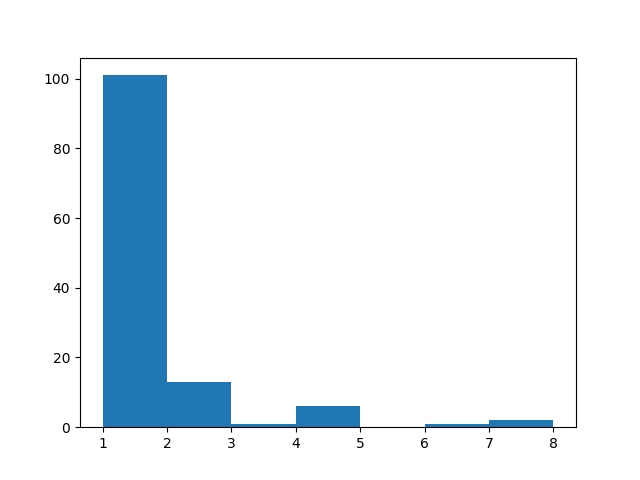

/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_16_hipp_left_skan_2019-10-11_135612/hist.png


In [41]:
plt.hist(ieg_pos_count, bins=range(int(min(ieg_pos_count)), int(max(ieg_pos_count) + 1), 1))
fig = plt.gcf()
savepath = result.path + "/hist.png"
print(savepath)
plt.savefig(savepath)

In [40]:
int(min(ieg_pos_count))

1